SaliStruct Evaluation Analysis
--------------------------

This notebook documents the evaluation of predicted usability scores for mobile UI screenshots using saliency-based metrics. The predictions are compared against the ground truth `usability_rating` from the UICrit dataset.

Approach:
- Generate saliency maps (e.g., using Grad-CAM or other models)
- Compute visual attention and structure metrics
- Combine them into a composite usability score
- Evaluate predicted scores against human ratings

Dataset:
- [UICrit](https://github.com/google-research-datasets/uicrit) based on the RICO dataset
- Multiple usability ratings per screenshot per task
- We average ratings to one usability score per `rico_id`

Formulas:
- `UsabilityScore = f(entropy, clusters, COG, symmetry, coverage, placement)`
- Grad-CAM used as one of the saliency models

Note:
- Predicted scores range from 0–1
- Actual `usability_rating` ranges from 1–10
- We'll scale predicted scores ×10 for meaningful comparison

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

# Load evaluation results
saliency_model = 'gradcam'
meta_df = pd.read_csv(f'../data/uicrit/uicrit_public.csv')
eval_df = pd.read_csv(f'../eval/uicrit/uicrit_eval_results_{saliency_model}.csv')

# Overview
print(f"Total samples: {len(eval_df)}")
eval_df[['usability_rating', 'predicted_score']].describe()


Total samples: 1000


,usability_rating,predicted_score
count,1000.000000,1000.000000
mean,5.816083,7.596517
std,0.643308,0.341079
min,3.333333,6.339700
25%,5.333333,7.368400
50%,5.666667,7.637950
75%,6.333333,7.857550
max,7.666667,8.284600


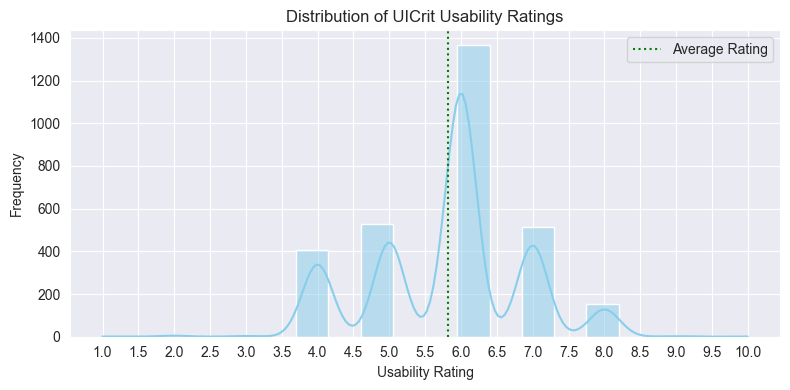

In [2]:
# Plot distribution of all UICrit usability scores
plt.figure(figsize=(8, 4))
sns.histplot(meta_df['usability_rating'], bins=20, kde=True, color='skyblue')
plt.xticks(ticks=[i/2 for i in range(2, 21)])  # Tick marks from 1.0 to 10.0 by 0.5
plt.axvline(meta_df['usability_rating'].mean(), color='green', linestyle=':', label='Average Rating')
plt.title("Distribution of UICrit Usability Ratings")
plt.xlabel("Usability Rating")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

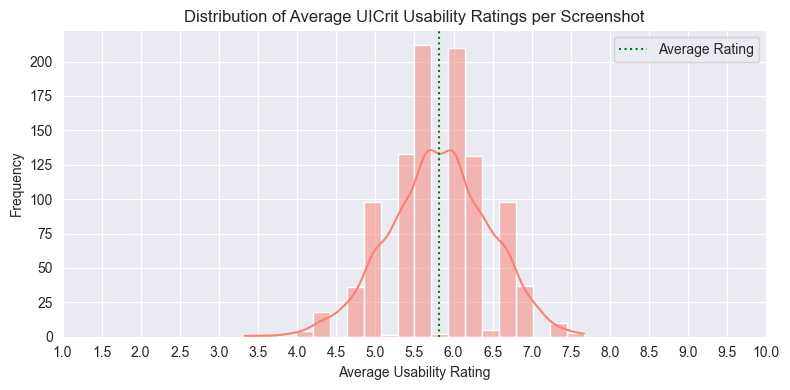

In [3]:
# Plot distribution of average UICrit scores per RICO ID
avg_df = meta_df.groupby('rico_id')['usability_rating'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.histplot(avg_df['usability_rating'], bins=20, kde=True, color='salmon')
plt.xticks(ticks=[i/2 for i in range(2, 21)])  # Tick marks from 1.0 to 10.0 by 0.5
plt.axvline(avg_df['usability_rating'].mean(), color='green', linestyle=':', label='Average Rating')
plt.title("Distribution of Average UICrit Usability Ratings per Screenshot")
plt.xlabel("Average Usability Rating")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x='usability_rating', y='predicted_score', data=eval_df, alpha=0.6)
plt.plot([0, 10], [0, 10], '--', color='gray')
plt.xlabel("Actual Usability Rating")
plt.ylabel("Predicted Usability Score (Scaled)")
plt.title(f"Predicted vs. Actual Usability ({saliency_model})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Correlation analysis
pearson_corr, _ = pearsonr(eval_df["usability_rating"], eval_df["predicted_score"])
spearman_corr, _ = spearmanr(eval_df["usability_rating"], eval_df["predicted_score"])

print(f"\n📈 Pearson correlation: {pearson_corr:.3f}")
print(f"🔁 Spearman correlation: {spearman_corr:.3f}")


📈 Pearson correlation: 0.012
🔁 Spearman correlation: 0.008


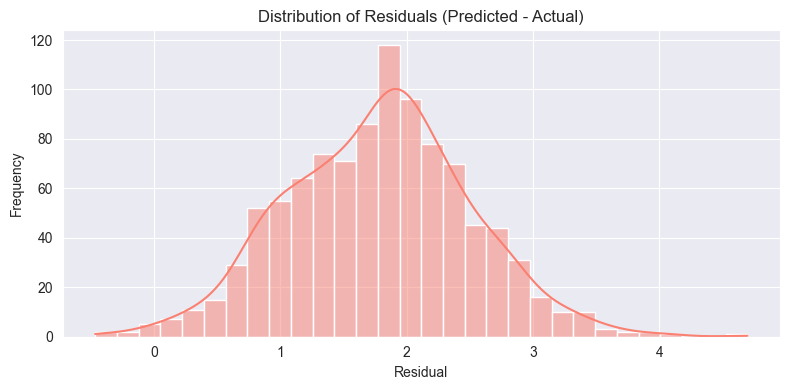

In [5]:
# Residuals and error metrics
eval_df['residual'] = eval_df['predicted_score'] - eval_df['usability_rating']
eval_df['abs_error'] = eval_df['residual'].abs()

# Residual distribution
plt.figure(figsize=(8, 4))
sns.histplot(eval_df['residual'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Residuals (Predicted - Actual)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

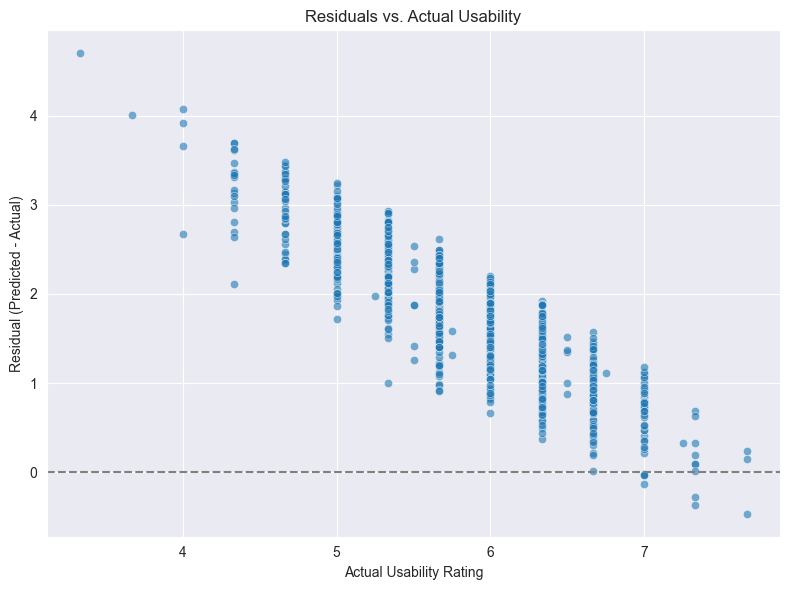

In [6]:
# Residuals vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x='usability_rating', y='residual', data=eval_df, alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Actual Usability Rating")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residuals vs. Actual Usability")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Top 5 outliers
outliers = eval_df.sort_values('abs_error', ascending=False).head(10)
print("🔎 Top 10 Outliers")
print(outliers[['filename', 'usability_rating', 'predicted_score', 'abs_error']])

🔎 Top 10 Outliers
      filename  usability_rating  predicted_score  abs_error
427  30809.jpg          3.333333           8.0299   4.696567
238  16155.jpg          4.000000           8.0785   4.078500
540  39384.jpg          3.666667           7.6744   4.007733
51    3710.jpg          4.000000           7.9147   3.914700
187  12732.jpg          4.333333           8.0272   3.693867
222  14829.jpg          4.333333           8.0227   3.689367
807  57929.jpg          4.000000           7.6609   3.660900
450  32956.jpg          4.333333           7.9570   3.623667
394  28672.jpg          4.333333           7.9426   3.609267
996  71747.jpg          4.666667           8.1478   3.481133


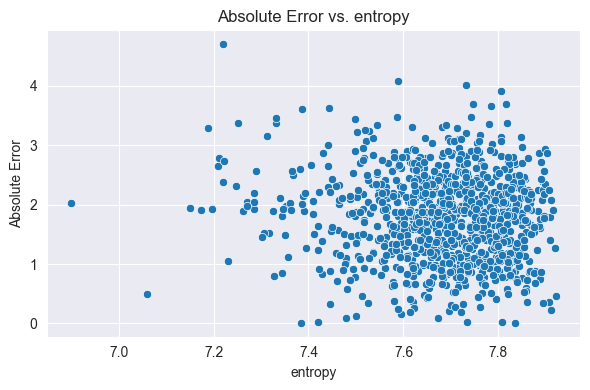

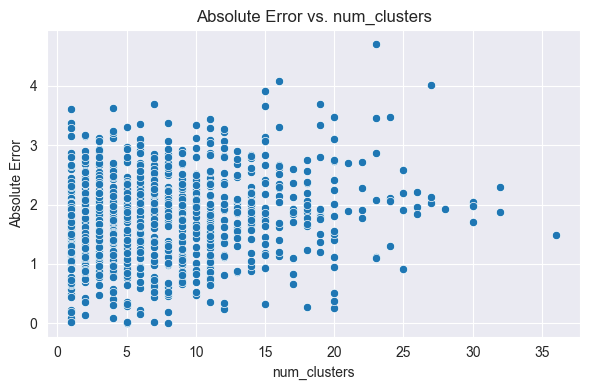

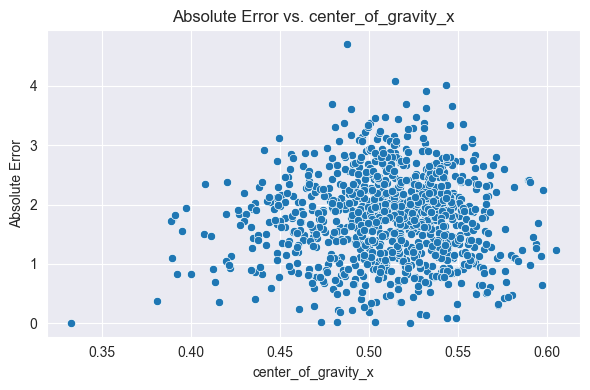

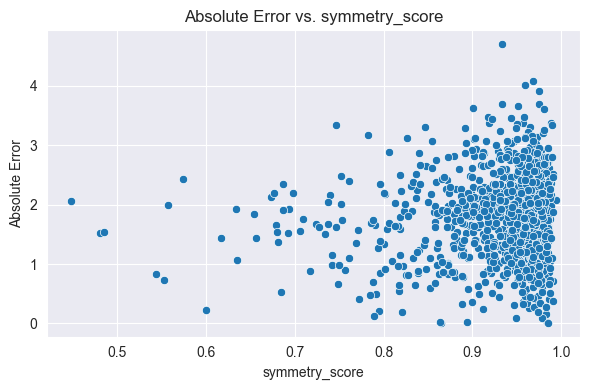

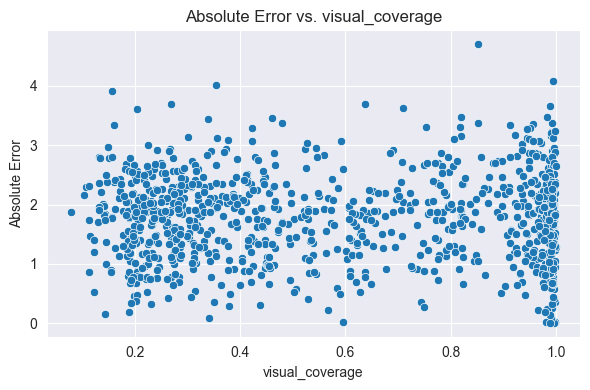

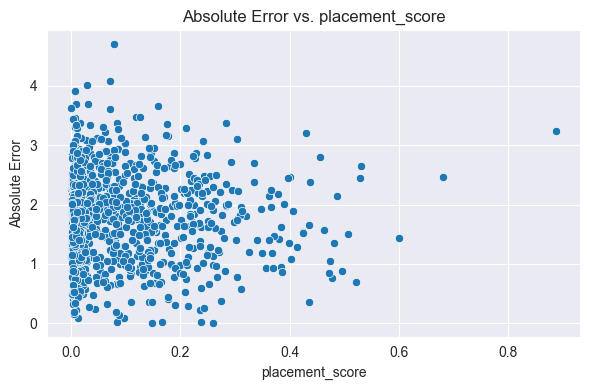

In [8]:
# Error breakdown by score components
component_cols = [
    'entropy', 'num_clusters', 'center_of_gravity_x',
    'symmetry_score', 'visual_coverage', 'placement_score'
]

for col in component_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=eval_df[col], y=eval_df['abs_error'])
    plt.title(f"Absolute Error vs. {col}")
    plt.xlabel(col)
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

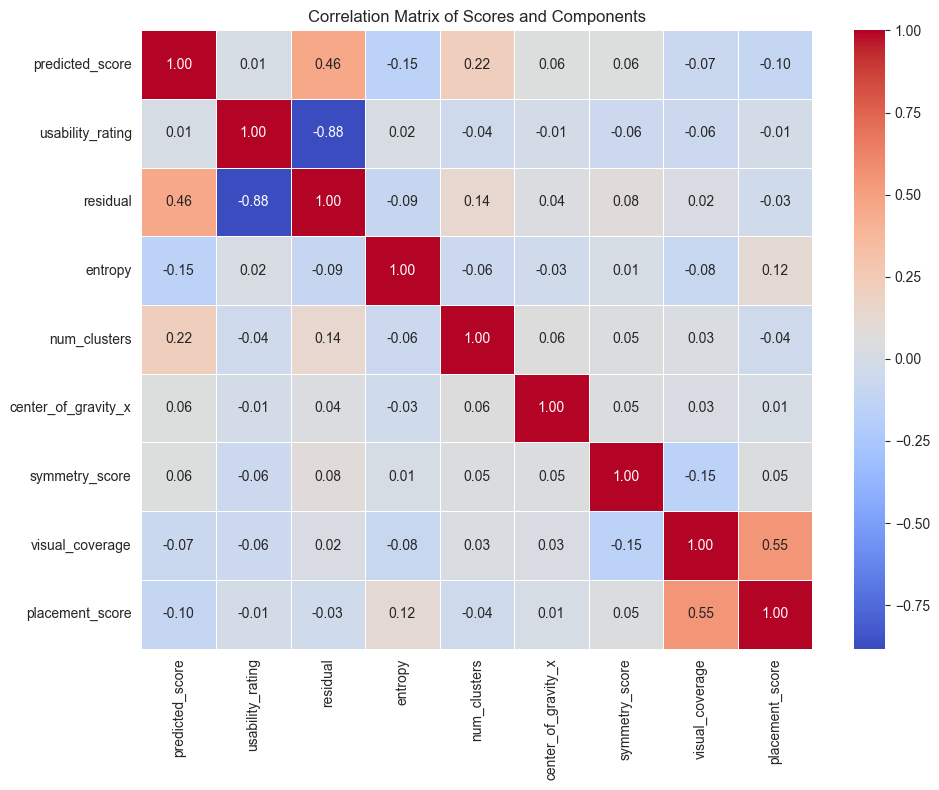

In [9]:
# Correlation matrix for all metrics
plt.figure(figsize=(10, 8))
corr_matrix = eval_df[['predicted_score', 'usability_rating', 'residual'] + component_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Scores and Components")
plt.tight_layout()
plt.show()